In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

qiskit_runtime_service.__init__:INFO:2023-12-22 08:06:01,789: Default instance: ibm-q/open/main


In [2]:
import qiskit.tools.jupyter

%qiskit_version_table

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import pylab

import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

from itertools import permutations #per brutal approches TSP

In [4]:
#draw a graph by coloring the nodes 
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

### TSP 

distance
 [[ 0. 90. 87.]
 [90.  0. 17.]
 [87. 17.  0.]]


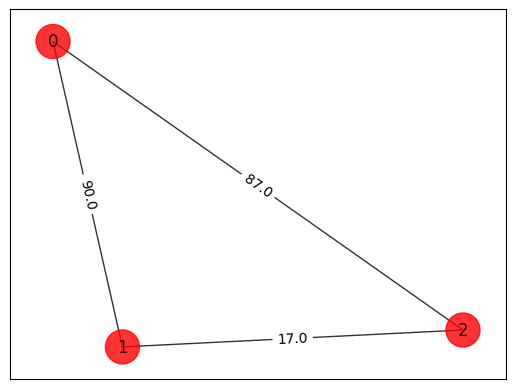

In [5]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n) 
#G=tsp.graph
#tsp = Tsp(G)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)
colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)


Define the Ising model

In [6]:
qp_tsp = tsp.to_quadratic_program()
qp2qubo_tsp = QuadraticProgramToQubo()
qubo_tsp = qp2qubo_tsp.convert(qp_tsp)
qubitOp_tsp, offset = qubo_tsp.to_ising()

In [7]:
# EXACT SOLUTION
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result_tsp_1 = ee.compute_minimum_eigenvalue(qubitOp_tsp)

print("energy:", result_tsp_1.eigenvalue.real)
print("tsp objective:", result_tsp_1.eigenvalue.real + offset)
x_tsp = tsp.sample_most_likely(result_tsp_1.eigenstate)
print("feasible:", qubo_tsp.is_feasible(x_tsp))
z_tsp = tsp.interpret(x_tsp)
print("solution:", z_tsp)
print("solution objective:", tsp.tsp_value(z_tsp, adj_matrix))

energy: -7087.0
tsp objective: 194.0
feasible: True
solution: [0, 1, 2]
solution objective: 194.0


In [8]:
#algorithm_globals.random_seed = 123
#seed = 10598

In [9]:
optimizer = COBYLA(maxiter=300, tol=0.5)
ry= TwoLocal(qubitOp_tsp.num_qubits, "ry", "cz", reps=2, entanglement="linear")
vqe= SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)
# run SamplingVQE 
while True:
    result=vqe.compute_minimum_eigenvalue(qubitOp_tsp)
    if qp_tsp.is_feasible(tsp.sample_most_likely(result.eigenstate)) == True:
        break

energy: -6672.322246647088
time: 13.404187202453613
feasible: True
solution: [0, 2, 1]
solution objective: 194.0


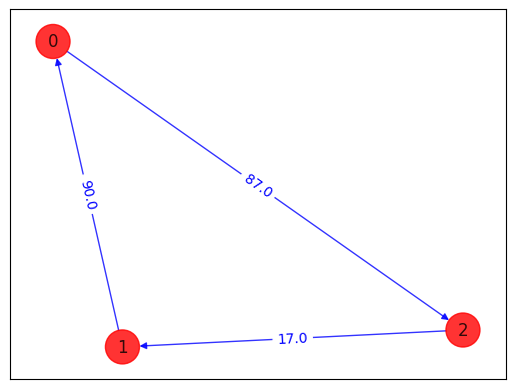

In [10]:
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)
#tsp.draw(x_cz, pos=pos_3)

In [11]:
# create the ANSATZ
theta = ParameterVector('theta', qubitOp_tsp.num_qubits)
ansatz = QuantumCircuit(qubitOp_tsp.num_qubits)
for i in range (0,qubitOp_tsp.num_qubits, tsp.graph.number_of_nodes()):
    ansatz.x(i)
    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
        ansatz.ry(theta[j-1], j)
        ansatz.cz(j-1,j)
        ansatz.ry(-theta[j-1], j)
    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
        ansatz.cx(j,j-1)

In [12]:
optimizer = COBYLA(maxiter=300, tol=0.5)
vqe= SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer)
# run SamplingVQE 
while True:
    result=vqe.compute_minimum_eigenvalue(qubitOp_tsp)
    if qp_tsp.is_feasible(tsp.sample_most_likely(result.eigenstate)) == True:
        break

energy: -6571.587826412914
time: 0.7345790863037109
feasible: True
solution: [0, 1, 2]
solution objective: 194.0


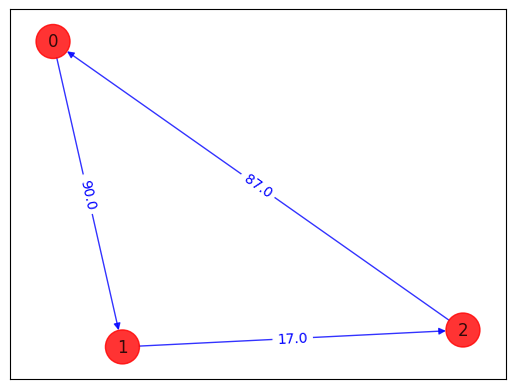

In [13]:
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)
#tsp.draw(x_cz, pos=pos_3)

distance
 [[ 0. 81. 63. 42.]
 [81.  0. 71. 44.]
 [63. 71.  0. 39.]
 [42. 44. 39.  0.]]


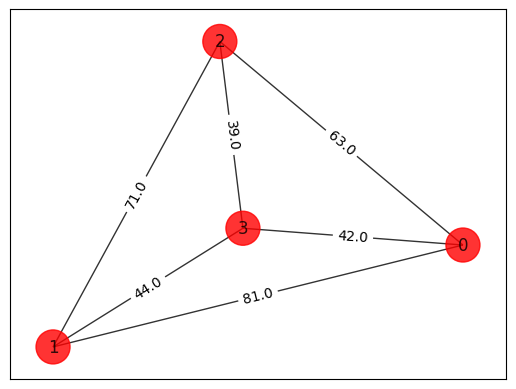

In [14]:
# Generating a graph of 3 nodes
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n) 
#G=tsp.graph
#tsp = Tsp(G)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)
colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [15]:
qp_tsp = tsp.to_quadratic_program()
qp2qubo_tsp = QuadraticProgramToQubo()
qubo_tsp = qp2qubo_tsp.convert(qp_tsp)
qubitOp_tsp, offset = qubo_tsp.to_ising()

In [16]:
# EXACT SOLUTION
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result_tsp_1 = ee.compute_minimum_eigenvalue(qubitOp_tsp)

print("energy:", result_tsp_1.eigenvalue.real)
print("tsp objective:", result_tsp_1.eigenvalue.real + offset)
x_tsp = tsp.sample_most_likely(result_tsp_1.eigenstate)
print("feasible:", qubo_tsp.is_feasible(x_tsp))
z_tsp = tsp.interpret(x_tsp)
print("solution:", z_tsp)
print("solution objective:", tsp.tsp_value(z_tsp, adj_matrix))

energy: -43996.0
tsp objective: 220.0
feasible: True
solution: [0, 3, 1, 2]
solution objective: 220.0


In [19]:
# create the ANSATZ
theta = ParameterVector('theta', qubitOp_tsp.num_qubits)
ansatz = QuantumCircuit(qubitOp_tsp.num_qubits)
for i in range (0,qubitOp_tsp.num_qubits, tsp.graph.number_of_nodes()):
    ansatz.x(i)
    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
        ansatz.ry(theta[j-1], j)
        ansatz.cz(j-1,j)
        ansatz.ry(-theta[j-1], j)
    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
        ansatz.cx(j,j-1)

In [21]:
optimizer = COBYLA(maxiter=100)
vqe= SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer)
# run SamplingVQE 
while True:
    result=vqe.compute_minimum_eigenvalue(qubitOp_tsp)
    if qp_tsp.is_feasible(tsp.sample_most_likely(result.eigenstate)) == True:
        break

energy: -43985.87496303683
time: 32.48316550254822
feasible: True
solution: [0, 1, 3, 2]
solution objective: 227.0


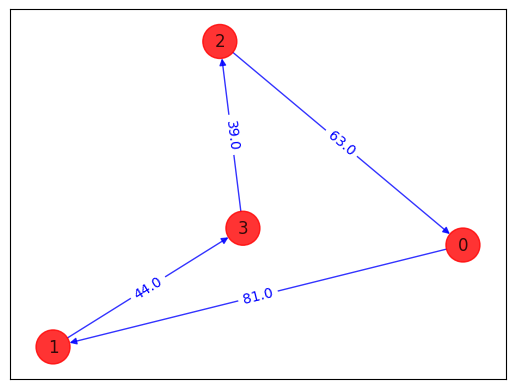

In [22]:
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)
#tsp.draw(x_cz, pos=pos_3)